In [20]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("/content/Original_Airbnb_Dataset.csv")

# Check first rows
print(df.head())

        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service fee minimum nights  \
0  40.64749 -73.97237  United St

/tmp/ipython-input-2394381721.py:4: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/Original_Airbnb_Dataset.csv")


In [21]:
df.info()

drop_cols = [
    'NAME', 'host name', 'neighbourhood', 'country code', 'license',
    'country', 'house_rules'
]

# Ensure columns are trimmed for reliable dropping
df.columns = [c.strip() for c in df.columns]
to_drop = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=to_drop)

print(f"Dropped {len(to_drop)} columns:", to_drop)
print("Remaining columns:", list(df.columns))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [22]:
df.isnull().sum()

,0
id,0
host id,0
host_identity_verified,289
neighbourhood group,29
lat,8
long,8
instant_bookable,105
cancellation_policy,76
room type,0
Construction year,214


In [23]:
# Handle missing values for each column based on ML best practices
import numpy as np
from datetime import datetime

# Treat categorical/object columns
df['host_identity_verified'] = df['host_identity_verified'].fillna('unknown')
df['instant_bookable'] = df['instant_bookable'].fillna('unknown')
df['cancellation_policy'] = df['cancellation_policy'].fillna(df['cancellation_policy'].mode()[0])
df['room type'] = df['room type'].fillna(df['room type'].mode()[0])

# Neighbourhood group: impute with mode; if lat/long also missing, drop row
missing_group = df['neighbourhood group'].isnull()
missing_latlong = df['lat'].isnull() | df['long'].isnull()
to_drop = missing_group & missing_latlong
df = df[~to_drop]
df['neighbourhood group'] = df['neighbourhood group'].fillna(df['neighbourhood group'].mode()[0])


# Lat/long: drop if missing (already handled above)
df = df.dropna(subset=['lat', 'long'])

# Construction year: impute with median, add missing flag
df['is_construction_year_missing'] = df['Construction year'].isnull().astype(int)
df['Construction year'] = df.groupby('room type')['Construction year'].transform(
    lambda x: x.fillna(x.median())
)
# If still missing, fill with overall median
df['Construction year'] = df['Construction year'].fillna(df['Construction year'].median())

# Target columns: drop rows with missing price or service fee
df = df.dropna(subset=['price', 'service fee'])

# Minimum nights: impute with median by room type
df['minimum nights'] = df.groupby('room type')['minimum nights'].transform(
    lambda x: x.fillna(x.median())
)
df['minimum nights'] = df['minimum nights'].fillna(df['minimum nights'].median())

# Number of reviews: fill 0 if missing
df['is_num_reviews_missing'] = df['number of reviews'].isnull().astype(int)
df['number of reviews'] = df['number of reviews'].fillna(0)

df['last review'] = pd.to_datetime(df['last review'], format='%m/%d/%Y', errors='coerce')
today = pd.Timestamp(datetime.now())
df['days_since_last_review'] = (today - df['last review']).dt.days
sentinel = df['days_since_last_review'].max() + 1 if df['days_since_last_review'].notna().any() else 999999
df['days_since_last_review'] = df['days_since_last_review'].fillna(sentinel).astype('int64')
df['is_last_review_missing'] = df['last review'].isna().astype(int)


# Reviews per month: fill 0 if number of reviews == 0, else median
df.loc[df['number of reviews'] == 0, 'reviews per month'] = 0
df['reviews per month'] = df['reviews per month'].fillna(
    df.groupby('room type')['reviews per month'].transform('median')
)
df['reviews per month'] = df['reviews per month'].fillna(0)

# Review rate number: fill with median by room type
df['review rate number'] = df.groupby('room type')['review rate number'].transform(
    lambda x: x.fillna(x.median())
)
df['review rate number'] = df['review rate number'].fillna(df['review rate number'].median())

# Calculated host listings count: fill with median
df['calculated host listings count'] = df['calculated host listings count'].fillna(
    df['calculated host listings count'].median()
)

# Availability 365: fill with median by room type
df['availability 365'] = df.groupby('room type')['availability 365'].transform(
    lambda x: x.fillna(x.median())
)
df['availability 365'] = df['availability 365'].fillna(df['availability 365'].median())

print("Missing value treatment done! Remaining nulls:\n", df.isnull().sum())


Missing value treatment done! Remaining nulls:
 id                                    0
host id                               0
host_identity_verified                0
neighbourhood group                   0
lat                                   0
long                                  0
instant_bookable                      0
cancellation_policy                   0
room type                             0
Construction year                     0
price                                 0
service fee                           0
minimum nights                        0
number of reviews                     0
last review                       15842
reviews per month                     0
review rate number                    0
calculated host listings count        0
availability 365                      0
is_construction_year_missing          0
is_num_reviews_missing                0
days_since_last_review                0
is_last_review_missing                0
dtype: int64


In [24]:
for col in ['price', 'service fee']:
    df[col] = (df[col].astype(str)
                        .str.replace(r'[^0-9.\-]', '', regex=True)
                        .replace('', np.nan)
                        .astype(float))
df = df.dropna(subset=['price', 'service fee'])



In [25]:
# Compute all quantiles at once
q = df[['price', 'service fee']].quantile([0.01, 0.99])

# Apply combined filter
df = df[
    (df['price'] >= q.loc[0.01, 'price']) & (df['price'] <= q.loc[0.99, 'price']) &
    (df['service fee'] >= q.loc[0.01, 'service fee']) & (df['service fee'] <= q.loc[0.99, 'service fee'])
]



In [26]:
current_year = pd.Timestamp.today().year
df['property_age'] = current_year - df['Construction year']
df['review_density'] = df['number of reviews'] / (df['days_since_last_review'] + 1)


In [27]:
cat_cols = ['host_identity_verified', 'instant_bookable', 'cancellation_policy', 'room type', 'neighbourhood group']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

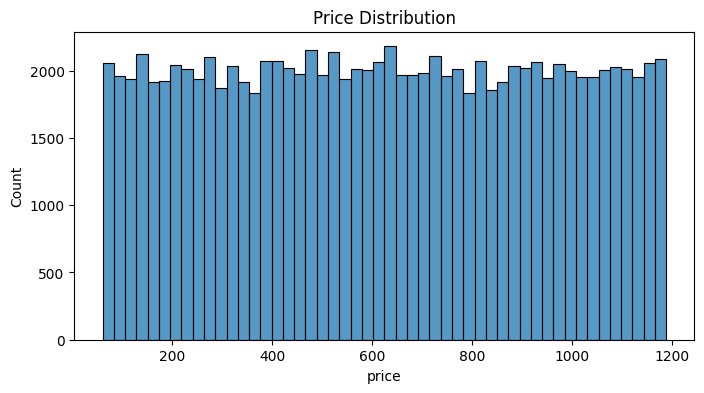

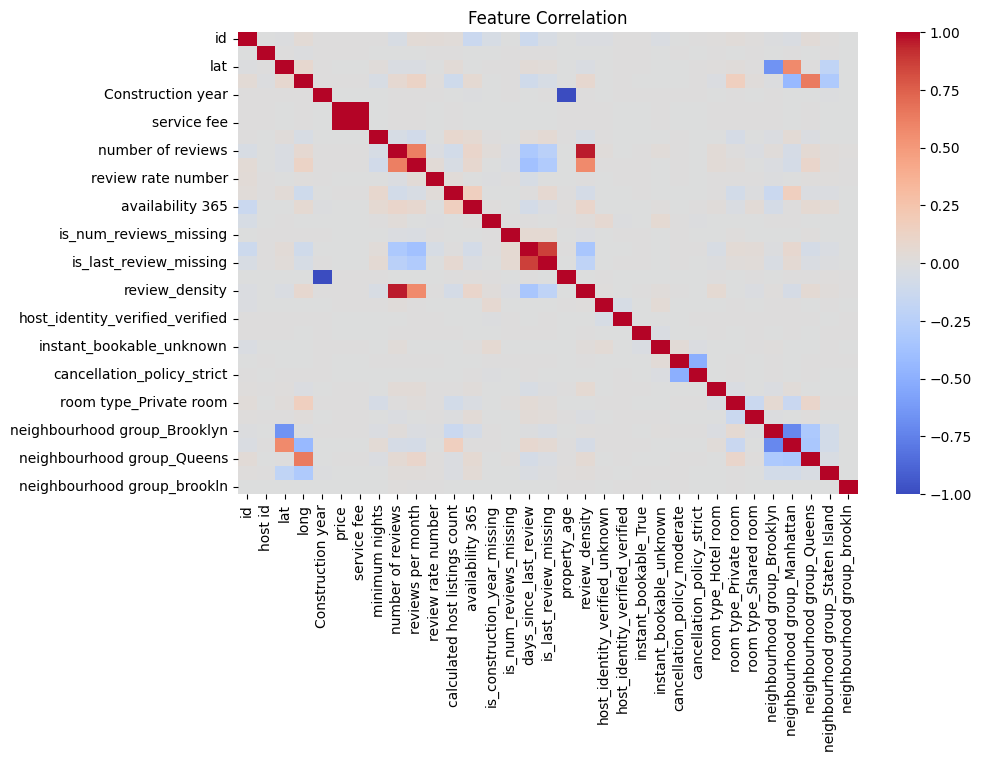

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Price distribution
plt.figure(figsize=(8,4))
sns.histplot(df['price'], bins=50)
plt.title('Price Distribution')

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Feature Correlation')

plt.show()


In [29]:
from google.colab import files

# Save locally in Colab
df.to_csv('cleaned_airbnb_data.csv', index=False)

# Download to your computer
files.download('cleaned_airbnb_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>